In [28]:
from __future__ import print_function, division

In [46]:
import pandas as pd
from datetime import datetime
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
import datetime

In [127]:
pd.options.display.float_format = '{:.3f}'.format

In [32]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190706,190629, 190622, 190615, 190608, 190601,190525,190518,190511,190504, 190427,190420,190413,190406]
df = get_data(week_nums)

In [33]:
def get_daily_counts(row, max_counter,type_exit):
    counter = row[type_exit] - row["PREV_"+type_exit]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row[type_exit], row["PREV_"+type_exit])
    if counter > max_counter:
        return 0
    return counter

In [34]:
def clean_data(df):
    
    #Clean column names
    df.columns = df.columns.str.strip()
    
    #Add datetime
    df['DATETIME'] = pd.to_datetime(df['DATE']+' '+df['TIME'],format="%m/%d/%Y %H:%M:%S")
    
    df.head()
    
    #Add DAY_OF_WEEK column
    #df['DAY_OF_WEEK'] = pd.to_datetime(df["DATETIME"], errors='coerce').dt.weekday_name
    
    #Get rid of duplicate entries
    df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"],inplace=True, ascending=False)
    df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)
    
    #Drop DESC column
    turnstiles_df1 = df.drop(["DESC"], axis=1, errors="ignore")
    
    #Counting Entries and Exits
    turnstiles_daily_time = (turnstiles_df1.groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME","LINENAME"],as_index=False)['ENTRIES','EXITS'].first())
    turnstiles_daily_time[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_daily_time
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["DATETIME","ENTRIES","EXITS"]
                                                       .transform(lambda grp: grp.shift(1)))
    turnstiles_daily_time.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
    # If counter is > 1Million, then the counter might have been reset.  
    # Just set it to zero as different counters have different cycle limits
    turnstiles_daily_time["HOURLY_ENTRIES"] = turnstiles_daily_time.apply(get_daily_counts, axis=1, max_counter=10000, type_exit ='ENTRIES')
    turnstiles_daily_time["HOURLY_EXITS"] = turnstiles_daily_time.apply(get_daily_counts,axis = 1, max_counter = 10000, type_exit ='EXITS')
    
    #Clean '0' from Stations_Daily_Time
    turnstiles_daily_time['HOURLY_ENTRIES'].replace(0, np.nan, inplace=True)
    turnstiles_daily_time['HOURLY_EXITS'].replace(0,np.nan,inplace=True) 
    
    #Creating a Total Count Columns
    turnstiles_daily_time['TOTAL_COUNT'] = turnstiles_daily_time['HOURLY_ENTRIES']+turnstiles_daily_time['HOURLY_EXITS']
    
    #Cleaning up columns in turnstiles_daily
    turnstiles_daily_clean = turnstiles_daily_time.drop(["PREV_ENTRIES", "PREV_EXITS", "PREV_DATE", "EXITS", "ENTRIES"], axis=1, errors="ignore")
    
    #Dropping Stations outside of Manhattan
    turnstiles_daily_clean = turnstiles_daily_clean[(turnstiles_daily_clean.STATION != 'LACKAWANNA')&(turnstiles_daily_clean.STATION != 'KEW GARDENS')&
                                                    (turnstiles_daily_clean.STATION != 'JKSN HT-ROOSVLT')&(turnstiles_daily_clean.STATION != 'FLUSHING-MAIN')&
                                                   (turnstiles_daily_clean.STATION != 'JOURNAL SQUARE') & (turnstiles_daily_clean.STATION != 'JUNCTION BLVD')&
                                                   (turnstiles_daily_clean.STATION != 'CONEY IS-STILLW')]
    
    return turnstiles_daily_clean
    

In [35]:
truck_data = clean_data(df)

In [36]:
truck_data['DAY_OF_WEEK'] = pd.to_datetime(truck_data["DATETIME"], errors='coerce').dt.weekday_name

In [37]:
def timebin(element):
    if element >=6 and element <= 11:
        return "Breakfast"
    elif element >11 and element <=16:
        return "Lunch"
    elif element > 16 and element <=23:
        return "Dinner"
    else: 
        return "Late Night"

truck_data['HOURS']= truck_data['DATETIME'].dt.hour.apply(timebin)

In [38]:
def weekend(day):
    if day == 'Saturday' or day == 'Sunday':
        return 'Weekend'
    else:
        return 'Workweek'
truck_data['WEEK'] = truck_data['DAY_OF_WEEK'].apply(weekend)

In [39]:
truck_data.head()

,C/A,UNIT,SCP,STATION,DATETIME,LINENAME,HOURLY_ENTRIES,HOURLY_EXITS,TOTAL_COUNT,DAY_OF_WEEK,HOURS,WEEK
1,A002,R051,02-00-00,59 ST,2019-03-30 04:00:00,NQR456W,20.0,8.0,28.0,Saturday,Late Night,Weekend
2,A002,R051,02-00-00,59 ST,2019-03-30 08:00:00,NQR456W,23.0,46.0,69.0,Saturday,Breakfast,Weekend
3,A002,R051,02-00-00,59 ST,2019-03-30 12:00:00,NQR456W,107.0,88.0,195.0,Saturday,Lunch,Weekend
4,A002,R051,02-00-00,59 ST,2019-03-30 16:00:00,NQR456W,237.0,71.0,308.0,Saturday,Lunch,Weekend
5,A002,R051,02-00-00,59 ST,2019-03-30 20:00:00,NQR456W,345.0,56.0,401.0,Saturday,Dinner,Weekend


In [40]:
def getranking(df,positions, weektype, count = 0):
    #Create dictionary
    count = count
    df1 = (df.groupby(['STATION','LINENAME', 'WEEK', 'HOURS']).sum().reset_index())
    topx_dict = defaultdict(str)
    hours = ['Breakfast','Lunch','Dinner','Late Night']
    for k in hours:
        topx_dict[k] = (df1[(df1['WEEK'] == weektype)&(df1['HOURS'] == k)].reset_index().sort_values(by='TOTAL_COUNT',ascending=False).head(positions))
    #Replace NaN for top stations in dictionary
    if count == 0:
        df2 = filldata(df,topx_dict)
        topx_dict = getranking(df2,positions,weektype,count = 1)
    if count == 1:
        for k in hours:
            topx_dict[k] = topx_dict[k].drop(["index"], axis=1, errors="ignore")
    return topx_dict

In [41]:
#Fill Nan or 0's in top stations
def filldata(df, dictionary):
    for key in dictionary:
        length = len(dictionary[key])
    for k in range(length):
        station = dictionary[key].STATION
        df[(df.STATION == str(station))].fillna(df[(df.STATION == str(station))].TOTAL_COUNT.mean(), inplace=True)
    return df

In [96]:
#Get Top3
top3_weekend = getranking(truck_data,3,weektype ='Workweek')

In [97]:
top3_weekend['Breakfast']

,STATION,LINENAME,WEEK,HOURS,HOURLY_ENTRIES,HOURLY_EXITS,TOTAL_COUNT
310,GRD CNTRL-42 ST,4567S,Workweek,Breakfast,1249336.0,2170388.0,3405979.0
397,PATH NEW WTC,1,Workweek,Breakfast,503052.0,2174612.0,2639681.0
300,FULTON ST,2345ACJZ,Workweek,Breakfast,700038.0,1774254.0,2462140.0


In [44]:
hours = ['Breakfast','Lunch','Dinner','Late Night']
count = []
stations = []
for k in hours:
    count.append(top3_weekend[k]['TOTAL_COUNT'])
    stations.append(top3_weekend[k]['STATION'])

In [120]:
weekday_data = truck_data[(truck_data.WEEK == 'Workweek')]
weekday_data.head(20)
weekday_data = (truck_data.groupby(['STATION'])['TOTAL_COUNT'].sum().reset_index().sort_values('TOTAL_COUNT',ascending=False))

[Text(0, 0, '34 ST-PENN STA'),
 Text(0, 0, 'GRD CNTRL-42 ST'),
 Text(0, 0, '34 ST-HERALD SQ'),
 Text(0, 0, 'TIMES SQ-42 ST'),
 Text(0, 0, '14 ST-UNION SQ'),
 Text(0, 0, '23 ST'),
 Text(0, 0, '42 ST-PORT AUTH'),
 Text(0, 0, 'FULTON ST'),
 Text(0, 0, '86 ST'),
 Text(0, 0, '125 ST')]

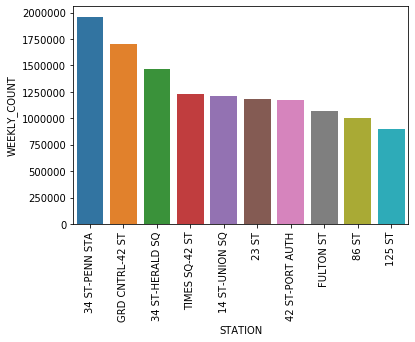

In [145]:
weekday_data['WEEKLY_COUNT'] = weekday_data.TOTAL_COUNT/14
stations = weekday_data.STATION.head(10)
count = weekday_data.WEEKLY_COUNT.head(10)
g = sns.barplot(stations,count)
g.set_xticklabels(stations, rotation=90)

In [199]:
top_stations = truck_data[(truck_data.STATION == '34 ST-PENN STA')|(truck_data.STATION == 'GRD CNTRL-42 ST')|(truck_data.STATION == '34 ST-HERALD SQ')]
top_stations = top_stations.groupby(['STATION','DAY_OF_WEEK'])['TOTAL_COUNT'].sum().reset_index()

In [202]:
top_stations['DAY_AVERAGE'] = top_stations.TOTAL_COUNT/14

In [196]:
stations = top_stations.STATION.unique()
count = []
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for station in stations:
    for day in weekdays:
        count.append(top_stations[(top_stations.STATION == station)&(top_stations.DAY_OF_WEEK == day)]['TOTAL_COUNT'])


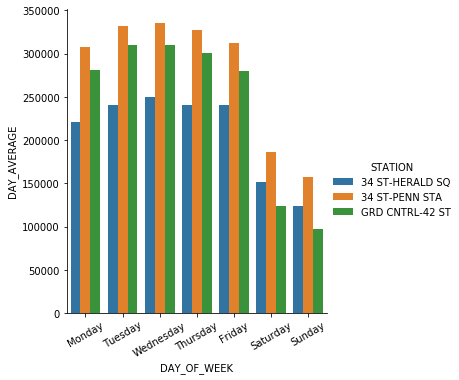

In [203]:
g = sns.catplot(x = 'DAY_OF_WEEK', y = 'DAY_AVERAGE', kind='bar', data = top_stations, hue = 'STATION', order = weekdays)
g.set_xticklabels(rotation=30)

In [194]:
count

[1   3095349.000
 Name: TOTAL_COUNT, dtype: float64, 5   3366955.000
 Name: TOTAL_COUNT, dtype: float64, 6   3502088.000
 Name: TOTAL_COUNT, dtype: float64, 4   3365967.000
 Name: TOTAL_COUNT, dtype: float64, 0   3361468.000
 Name: TOTAL_COUNT, dtype: float64, 2   2113234.000
 Name: TOTAL_COUNT, dtype: float64, 3   1739155.000
 Name: TOTAL_COUNT, dtype: float64, 8   4301385.000
 Name: TOTAL_COUNT, dtype: float64, 12   4651153.000
 Name: TOTAL_COUNT, dtype: float64, 13   4695299.000
 Name: TOTAL_COUNT, dtype: float64, 11   4589571.000
 Name: TOTAL_COUNT, dtype: float64, 7   4377327.000
 Name: TOTAL_COUNT, dtype: float64, 9   2613057.000
 Name: TOTAL_COUNT, dtype: float64, 10   2207277.000
 Name: TOTAL_COUNT, dtype: float64, 15   3929999.000
 Name: TOTAL_COUNT, dtype: float64, 19   4338781.000
 Name: TOTAL_COUNT, dtype: float64, 20   4345069.000
 Name: TOTAL_COUNT, dtype: float64, 18   4214553.000
 Name: TOTAL_COUNT, dtype: float64, 14   3921704.000
 Name: TOTAL_COUNT, dtype: float64, 16